# Scalegram
Utilizando la informacion de los tiempos de muestra, es posible hacer una transformada wavelet a cada canal para observar su contenido de frecuencias en el tiempo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import numpy as np
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# funciones personalizadas
from lib import import_file


# 1) Carga del archivo VERDAQ raw
# — ajusta la ruta al fichero real, p.ej. "0_raw/verDAQ8_data_2022_05_24_201646_00003.dat"
data_path = "../0_raw/verDAQ8_data_2022_05_26_131703_00000.dat"
df_original = import_file(data_path)

df_original = df_original.iloc[1:]

df_original.head()

,t,id,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,timestamp
1,1.653564e+09,800,3365,736,739,726,3362,2050,745,3341,2022-05-26 11:17:06.549341184
2,1.653564e+09,801,3957,149,152,144,3948,2895,153,3931,2022-05-26 11:17:06.549341184
3,1.653564e+09,802,3406,698,712,702,3381,2431,710,3383,2022-05-26 11:17:06.549341184
4,1.653564e+09,803,2746,1353,1370,1354,2726,3041,1371,2724,2022-05-26 11:17:06.549341184
5,1.653564e+09,804,3215,886,891,876,3210,3114,897,3191,2022-05-26 11:17:06.549341184


## uso de modelo lineal de timestamps
Se obtuvieron por distintas metodologias calculos de $\Delta T$, se considero como "el mejor" aquel que provocaba un menor drift, osea una menor diferencia entre el reloj predicho y el timestamp marcado en los datos.

Pero y si el timestamp simplemente esta mal?
Los datos llegan en batches de forma fractal, esto debido a las multiples capas de comunicacion que atraviesan los datos, al ser mas rapidos que el sistema de almacenamiento, llegan de a muchos batches y posiblemente de manera atrasada.
Podrian sser los datos en verdad un muestreo de 40 nano segundos como indica la tarjeta?
Esto es problematico pues implicaria descartar por completo los time stamps se los datos

In [2]:
# 2) Modelo lineal para timestamps

# 0.00129798   # s por muestra  # 0526 obtenido de sampling uniforme, drift de 8000 s /dia
# 0.013123511994454289          # 0527 obtenido de optimizacion, drift de 0.03 s / dia
# 40e-9                         # 05218 Mauro me comenta que el sampling de CMB es de 40 ns
                                    # mucho mas rapido que la computadora slave que recibe los datos
#coef = 40e-9  
coef = 50e-6
intercept = -0.030460957185257993  # s

n = len(df_original)
k = np.arange(n)
# Tiempo relativo en segundos
pred_secs = intercept + coef * k
t0 = df_original['timestamp'].iloc[0]
df_original['predicted_timestamp'] = t0 + pd.to_timedelta(pred_secs, unit='s')

In [3]:
# #%%time
# # =======================
# # === Testing ground ====
# # =======================

# df = df_original.copy().iloc[160:2600]

# # 1) Prepara df (ya cargado con df = pd.read_csv...)
# # Convertir canales de hex a int
# for ch in [f'ch{x}' for x in range(8)]:
#     df[ch] = df[ch].apply(lambda x: int(str(x), 16))

# x = df['ch0'].values
# times = df['predicted_timestamp'].values
# print(x.shape)

# # 0.00129798   # s por muestra  # 0526 obtenido de sampling uniforme, drift de 8000 s /dia
# # 0.013123511994454289          # 0527 obtenido de optimizacion, drift de 0.03 s / dia
# # 40e-9                         # 05218 Mauro me comenta que el sampling de CMB es de 40 ns
#                                     # mucho mas rapido que la computadora slave que recibe los datos
# #coef = 40e-9 
#     # hasta ahora si utilizamos estos 40 ns de sampling,
#     # el valor de coeficientes aumenta alrededor de los MHz, (supuestamente es una onda de 5MHz
#         # por tanto entre 10^6 Hz y 10^7 Hz esperamos ver unos peaks)


# # 4) CWT
# # tiempo de correr el codigo 128 -- 1[s]
# # 500 -- 2[s] 
# # 1000 -- 3[s]
# # 2000 -- 7[s]
# scales = np.arange(1, 400)
# coeffs, freqs = pywt.cwt(x, scales, 'morl', sampling_period=coef)
# # coeffs.shape = (frecuencias, extension temporal (len(x)))
# print(coeffs.shape)

# extent = [times[0], times[-1], freqs[-1], freqs[0]]  # Y de f_min a f_max
# im = plt.imshow(
#     np.abs(coeffs),
#     extent=extent,
#     aspect='auto'
# )
# plt.yscale('log')
# #plt.imshow(np.abs(coeffs))
# plt.show()


## Problematica de CWT
CWT y muchas tecnicas de wavelet asumen un sampleo uniforme, el sampling que tenemos es altamente no uniforme, ya sea si asumimos los time stamps originales o los inferidos; necesitamos que sea uniforme.

- es necesario entonces hacer una interpolacion en el caso de querer usar time stamps originales que se encuentran saltados
- los time stamps inferidos no poseen ese problema, ya que introducimos a fuerza un sampling uniforme


### Problematica de los timestamps originales
Es necesario asumir un $\Delta T$ subyacente que no se refleja en los datos, aqui se demuestra como trabajar con los time stamps originales es problematico y entrega soluciones no unicas.

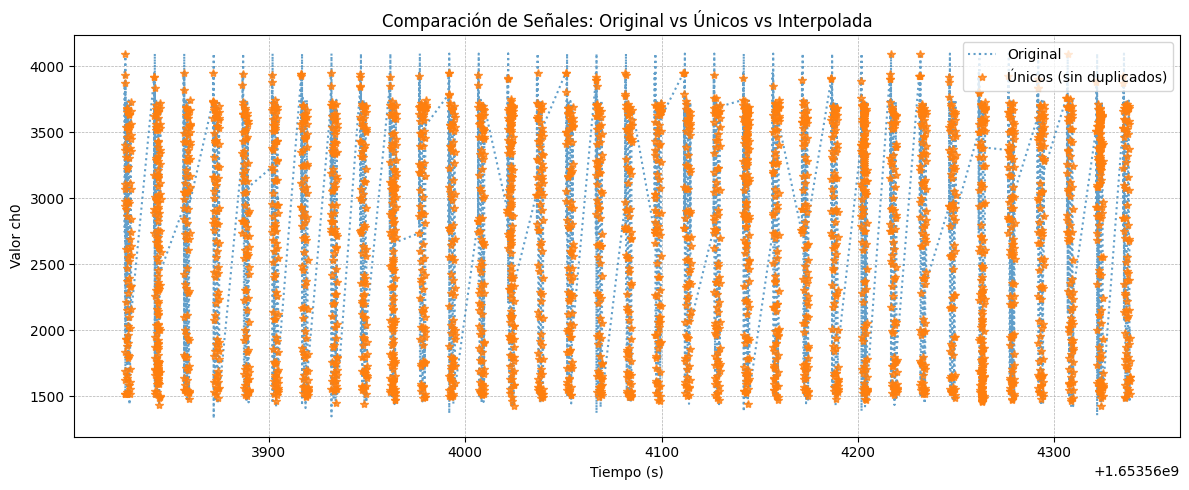

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ------------------------------------------------------------------------------
# 1) Carga y preparación de datos
# ------------------------------------------------------------------------------
df = df_original.copy()  # Fragmento ya seleccionado fuera de este snippet

# Convertir timestamps a segundos
times = df['timestamp'].astype('datetime64[ns]').view(np.int64) * 1e-9
signal = df['ch0'].astype(int).values

# ------------------------------------------------------------------------------
# 2) Eliminar duplicados en timestamps
# ------------------------------------------------------------------------------
unique_idx = np.unique(times, return_index=True)[1]
t_unique = times.iloc[unique_idx]
signal_unique = signal[unique_idx]

# ------------------------------------------------------------------------------
# 3) Interpolación en grilla uniforme
# ------------------------------------------------------------------------------
dt = 0.013123511994454289  # s (p. ej., obtenido con optimización previa)
t_uniform = np.arange(t_unique.iloc[0], t_unique.iloc[-1], dt)

interp_fn = interp1d(
    t_unique,
    signal_unique,
    kind='cubic',
    bounds_error=False,
    fill_value='extrapolate'
)
signal_uniform = interp_fn(t_uniform)

# ------------------------------------------------------------------------------
# 4) Trazado único con las tres series
# ------------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Señal original (punteado)
plt.plot(
    times, signal,
    linestyle=':',
    marker=None,
    label='Original',
    alpha=0.7
)

# Señal única (estrella)
plt.plot(
    t_unique, signal_unique,
    linestyle='',
    marker='*',
    label='Únicos (sin duplicados)',
    alpha=0.8
)

# # Señal interpolada (línea continua)
# plt.plot(
#     t_uniform, signal_uniform,
#     linestyle='-',
#     marker=None,
#     label='Interpolada (grilla uniforme)',
#     alpha=0.9
# )

plt.title('Comparación de Señales: Original vs Únicos vs Interpolada')
plt.xlabel('Tiempo (s)')
plt.ylabel('Valor ch0')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Usar PredictedTimeStamp

Basicamente solo se respeta la hora de inicio del experimento para hacer una identificacion de este,
sin embargo asumimos que los datos registrados en la computadora principal provienen de multiples buffers, por tanto no es el sampling original del verDAQ.

Asumimos que el verDAQ adquiere cada `40ns`

In [5]:
#coef = 40e-9  
coef = 50e-6 # preliminary review
intercept = -0.030460957185257993  # s

n = len(df_original)
k = np.arange(n)
# Tiempo relativo en segundos
pred_secs = intercept + coef * k
t0 = df_original['timestamp'].iloc[0]
df_original['predicted_timestamp'] = t0 + pd.to_timedelta(pred_secs, unit='s')

## Funcion de CWT

In [6]:
def cwt(df, channel = 'ch0', time_axis = 'timestamp', scale_max = 256):
    x = df[channel].values
    times = df[time_axis].values

    # 4) CWT
    scales = np.arange(1, scale_max)
    coeffs, freqs = pywt.cwt(x, scales, 'morl', sampling_period=coef)

    # 5) Gráfica señal vs tiempo y scalogram
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=False)

    # Señal vs timestamp
    ax1.plot(df[time_axis], x, '.', markersize=2)
    ax1.set_title(f'{channel} vs {time_axis}')
    ax1.set_ylabel('ADC Code')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # Scalogram
    extent = [times[0], times[-1], freqs[-1], freqs[0]]  # Y de f_min a f_max
    im = ax2.imshow(
        np.abs(coeffs),
        extent=extent,
        aspect='auto'
    )
    ax2.set_yscale('log')
    ax2.set_title('CWT Scalogram (ch0)')
    ax2.set_ylabel('Frecuencia [Hz]')
    ax2.set_xlabel('Sample Index')

    # Convertir eje Y a MHz
    # ax2.yaxis.set_major_formatter(
    #     ticker.FuncFormatter(lambda val, pos: f"{val:.3e}")
    # )
    ax2.set_ylabel('Frequency [Hz]')

    plt.tight_layout()
    plt.show()



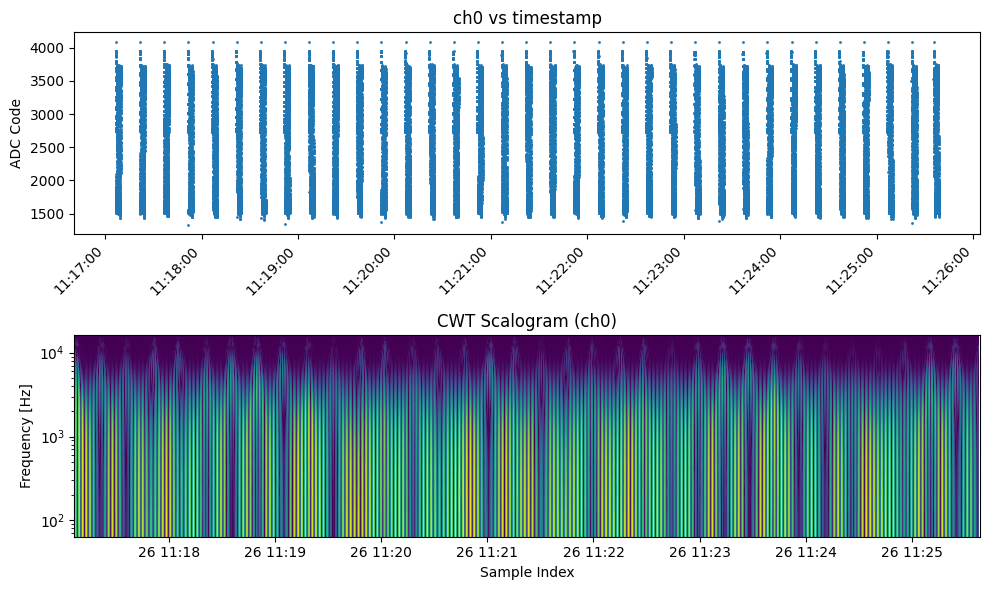

In [7]:
# timestamp no debe utilizarse
# pues cwt asume que son uniformes
cwt(df, 'ch0', 'timestamp', 256)

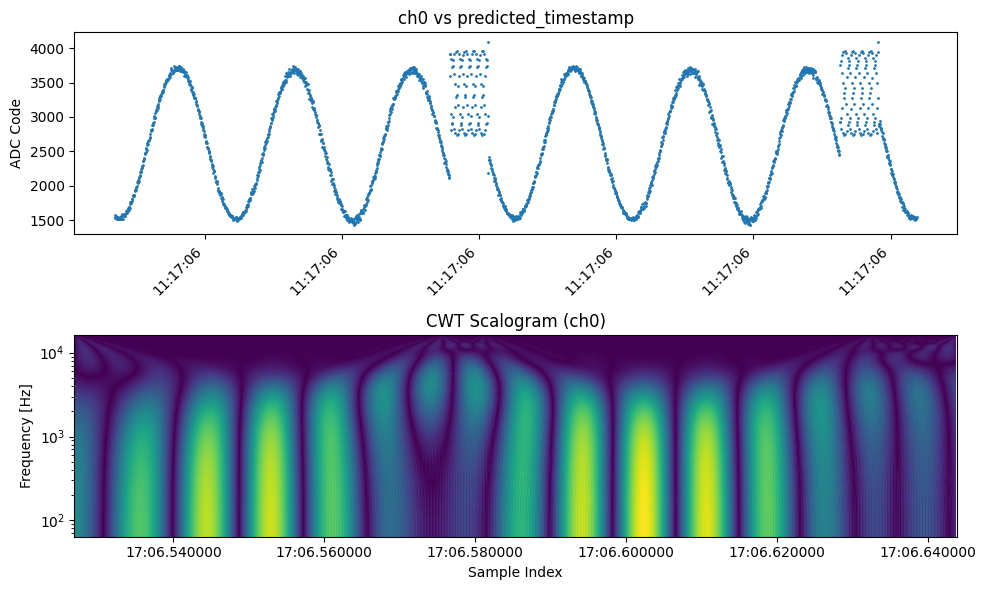

In [8]:
cwt(df.iloc[160:2500], 'ch0', 'predicted_timestamp', 256)

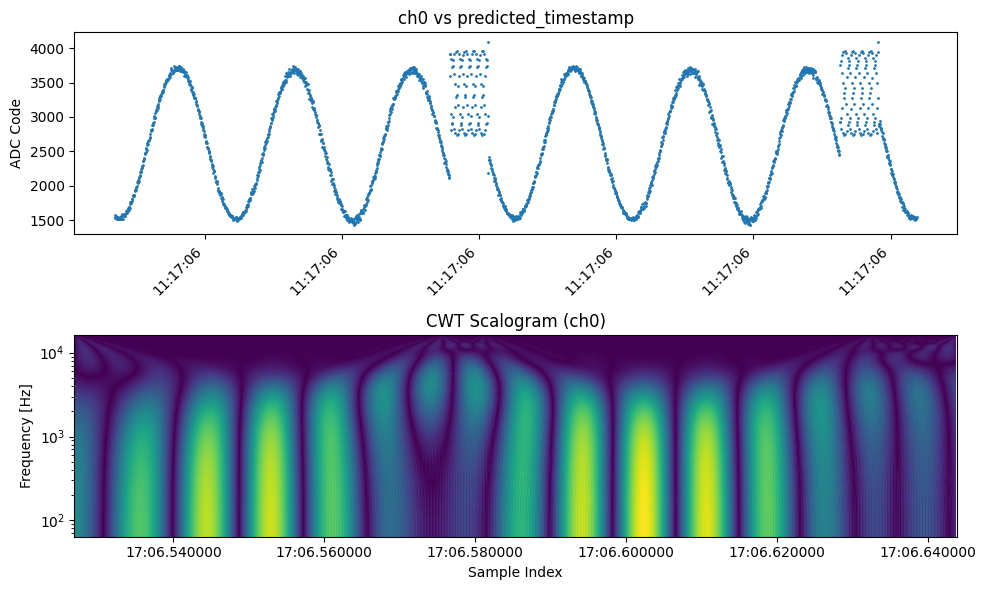

In [9]:
cwt(df.iloc[160:2500],'ch0', 'predicted_timestamp', 256)

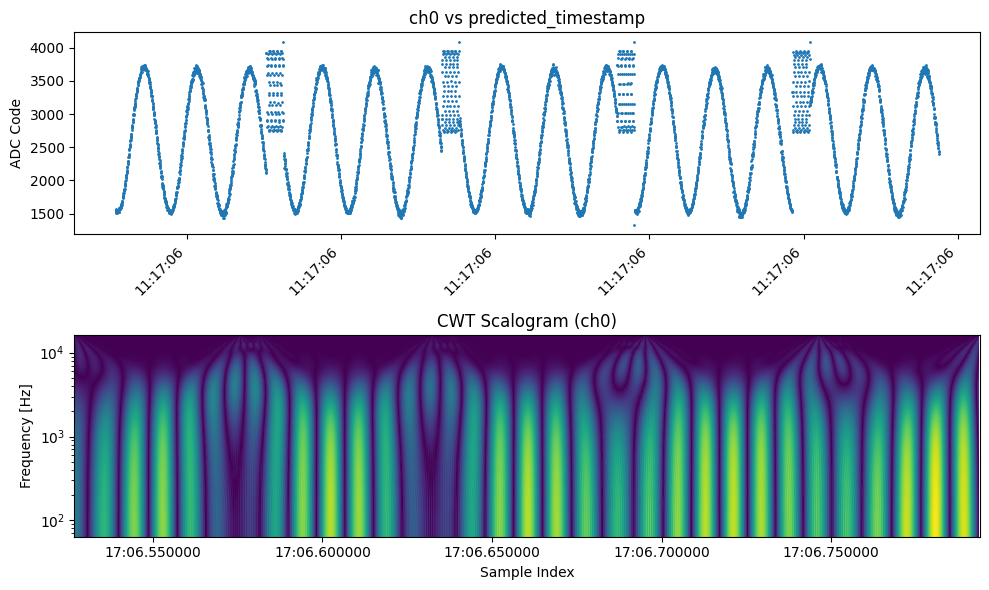

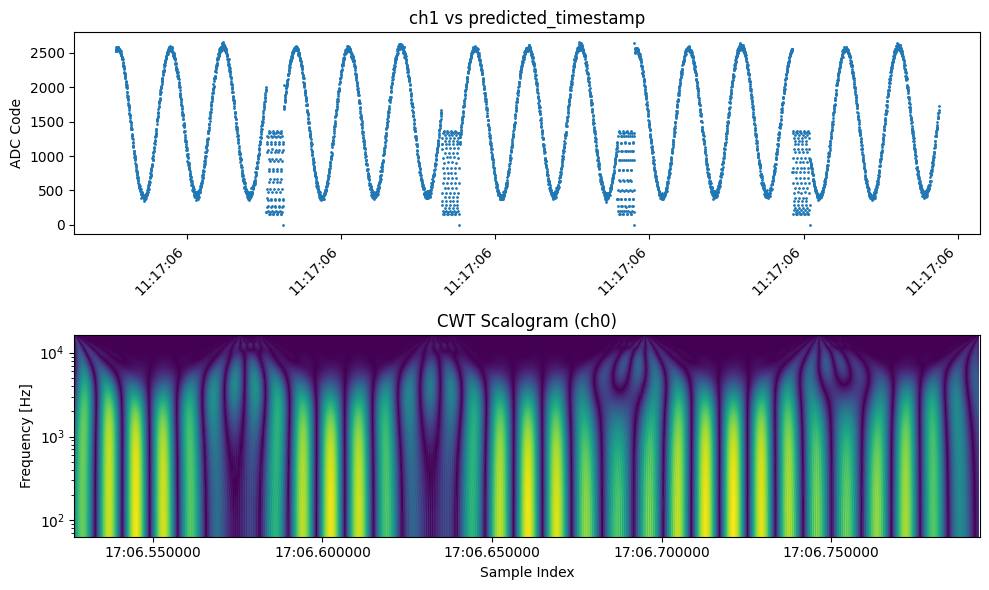

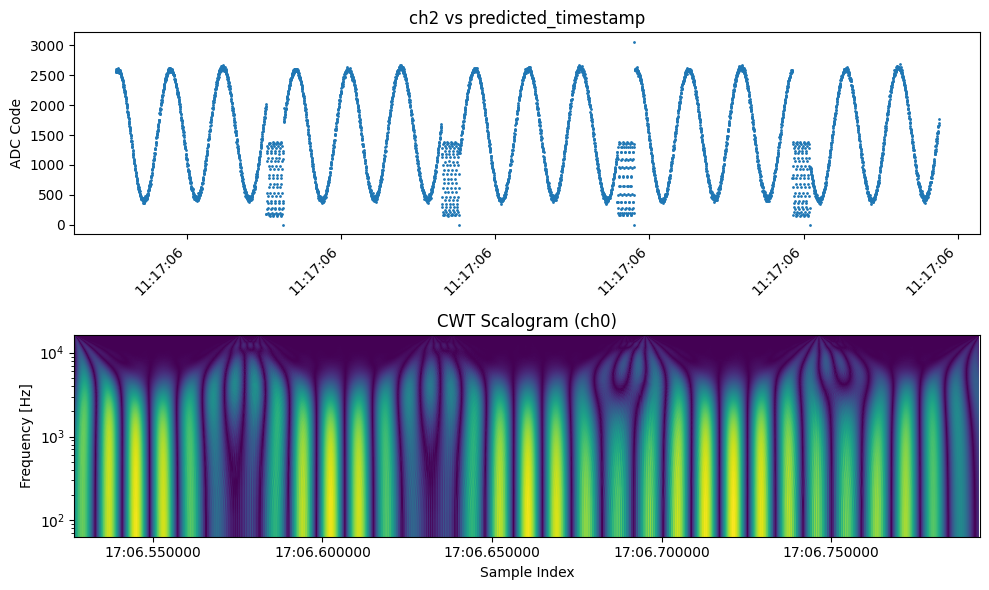

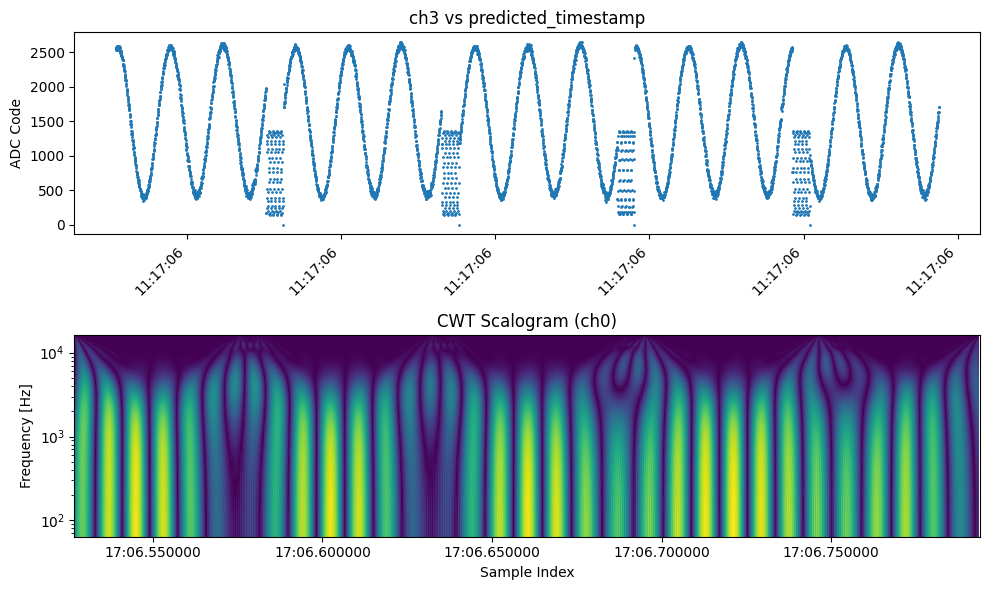

In [10]:
cwt(df.iloc[160:5500], 'ch0', 'predicted_timestamp', 256)
cwt(df.iloc[160:5500], 'ch1', 'predicted_timestamp', 256)
cwt(df.iloc[160:5500], 'ch2', 'predicted_timestamp', 256)
cwt(df.iloc[160:5500],'ch3', 'predicted_timestamp', 256)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import matplotlib.dates as mdates
from scipy.fft import rfft, rfftfreq

def analyze_frequencies(df, channel='ch0', coef=0.00129798, intercept=-0.030460957185257993):
    """
    Dado un DataFrame con muestras y el sampling period (coef),
    genera:
     1) Un scalogram CWT con el eje de frecuencia (Hz).
     2) Un espectro FFT para identificar los picos de frecuencia.
    """
    for ch in [f'ch{x}' for x in range(8)]:
        df[ch] = df[ch].apply(lambda x: int(str(x), 16))

    x = df[channel].values
    n = len(x)
    fs = 1.0 / coef               # frecuencia de muestreo en Hz

    # generar los time stamps en base a coef
    n = len(df)
    k = np.arange(n)
    # Tiempo relativo en segundos
    pred_secs = intercept + coef * k
    t0 = df['timestamp'].iloc[0]
    df['predicted_timestamp'] = t0 + pd.to_timedelta(pred_secs, unit='s')
    t0 = df['predicted_timestamp'].iloc[0]

    # ——— 1) CWT Scales → Frecuencias ———
    scales = np.arange(1, 128)
    # freqs en Hz: pywt.scale2frequency devuelve frecuencia relativa (1/dt)
    frequencies = pywt.scale2frequency('morl', scales) * fs
    coeffs, _ = pywt.cwt(x, scales, 'morl', sampling_period=coef)

    # Plot scalogram con eje de frecuencia
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(np.abs(coeffs), 
                   extent=[0, n, frequencies[-1], frequencies[0]],
                   aspect='auto',
                   cmap='jet')
    ax.set_ylabel('Frecuencia (Hz)')
    ax.set_yscale('log')
    ax.set_xlabel('Índice de muestra k')
    ax.set_title(f'CWT Scalogram ({channel})')
    fig.colorbar(im, ax=ax, label='|coef|')
    plt.tight_layout()
    plt.show()

    # ——— 2) FFT para espectro ———
    # Restar la media para centrar
    x_detrended = x - np.mean(x)
    # Transformada rápida de Fourier
    X = rfft(x_detrended)
    freqs = rfftfreq(n, d=coef)   # eje de frecuencia
    power = np.abs(X)

    # Plot espectro
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(freqs, power)
    ax.set_xlim(0, fs/2)
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Magnitud FFT')
    ax.set_title(f'Espectro FFT ({channel})')
    plt.tight_layout()
    plt.show()




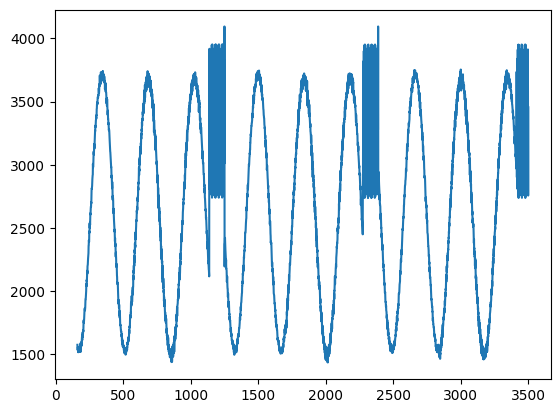

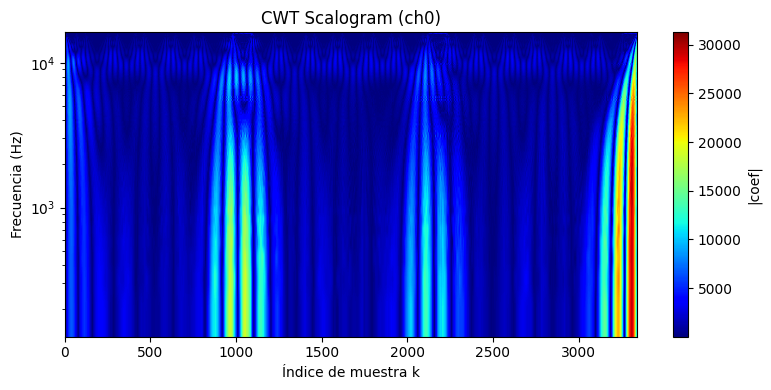

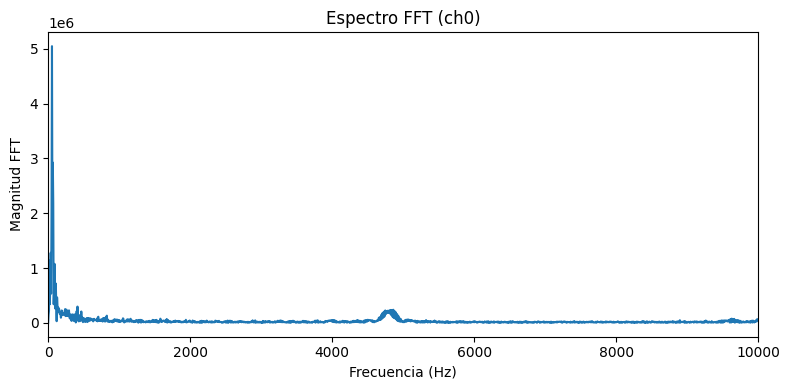

In [16]:
df = df_original.copy().iloc[160:3500]

tiempo_muestreo = coef #0.00129798

plt.plot(df['ch0'])
analyze_frequencies(df, channel='ch0', coef=tiempo_muestreo)

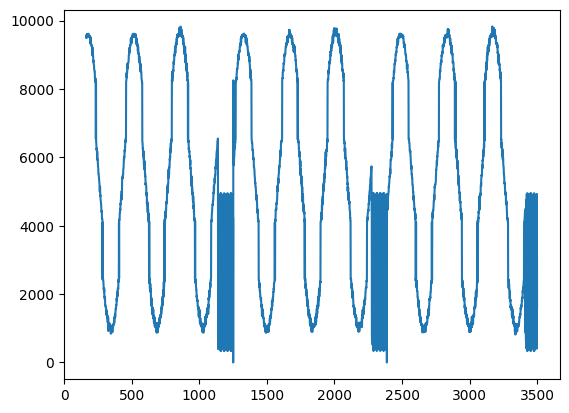

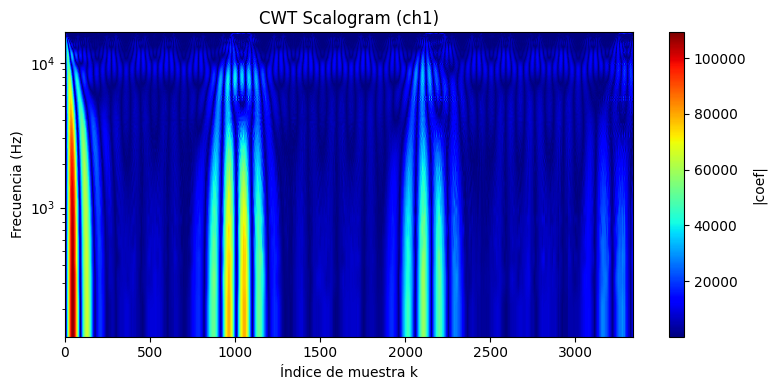

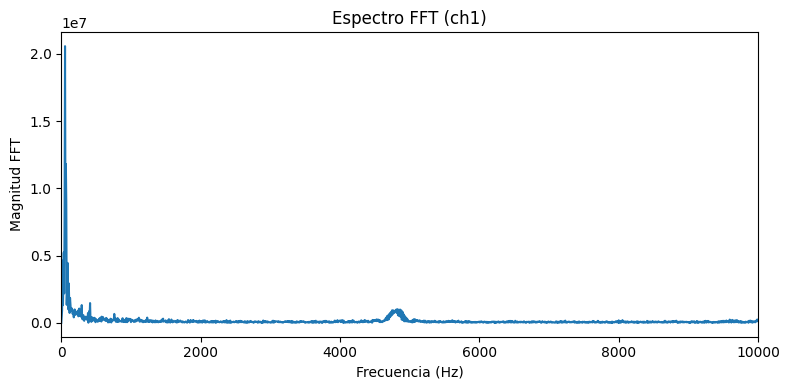

In [17]:
plt.plot(df['ch1'])
analyze_frequencies(df, channel='ch1', coef=tiempo_muestreo)

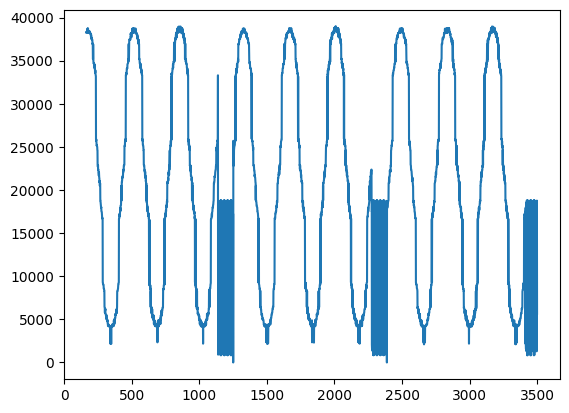

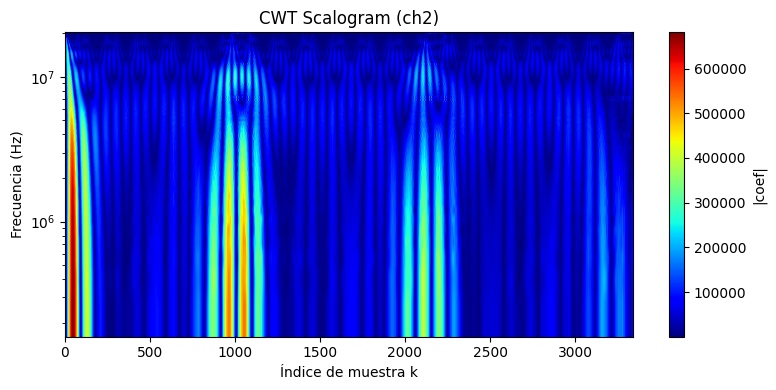

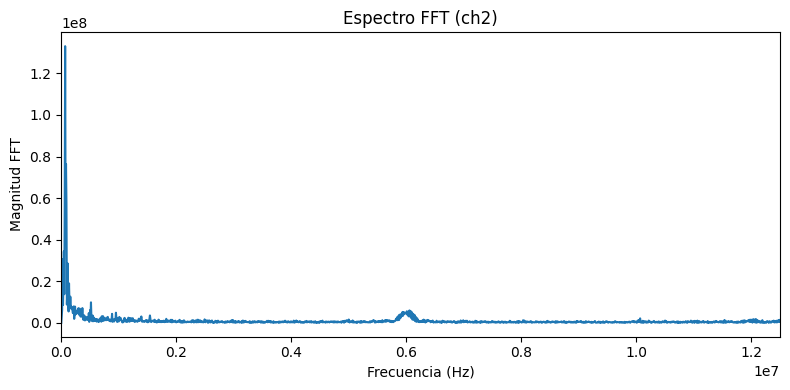

In [14]:
plt.plot(df['ch2'])
analyze_frequencies(df, channel='ch2', coef=tiempo_muestreo)

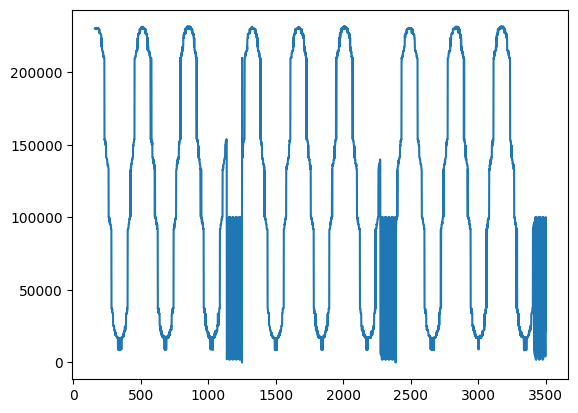

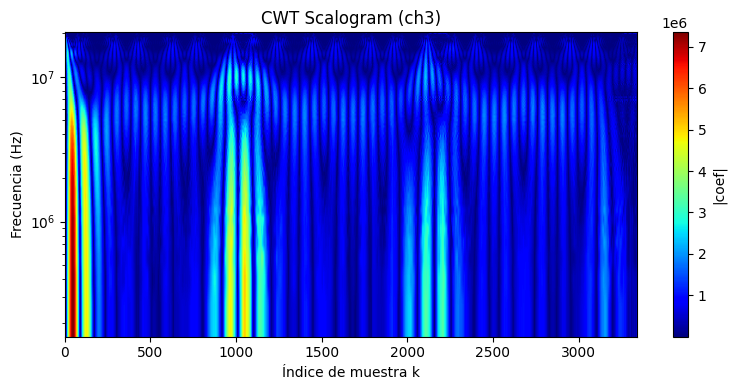

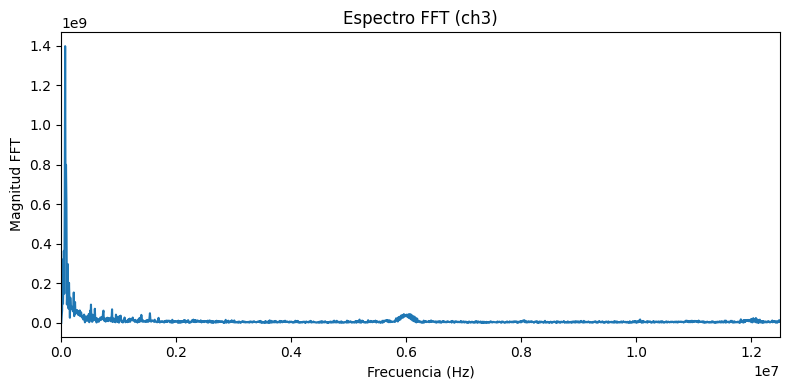

In [15]:
plt.plot(df['ch3'])
analyze_frequencies(df, channel='ch3', coef=tiempo_muestreo)